### Section C - (B)

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import uproot
from IPython.display import display
import time

In [10]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

event_ratio = 0.3

In [31]:
def load_data(file_paths, labels):
    """
    Loads ROOT files and extracts relevant features into a Pandas DataFrame.
    
    Parameters:
        file_paths (dict): Dictionary where keys are class labels and values are ROOT file paths.
        labels (dict): Dictionary mapping class labels to numeric values.
    
    Returns:
        pd.DataFrame: A DataFrame containing the extracted features and labels.
    """
    data = []
    
    for label, file_path in file_paths.items():
        with uproot.open(file_path) as f:
            tree = f["events"]  # Adjust this if the tree name is different
            
            # Load features
            thrust_x = tree["Thrust_x"].array(library="np")
            thrust_y = tree["Thrust_y"].array(library="np")
            thrust_z = tree["Thrust_z"].array(library="np")
            n_particles = tree["nParticle"].array(library="np")
            n_vertices = tree["nVertex"].array(library="np")
            vertex_ntracks = tree["Vertex_ntracks"].array(library="np")
            vertex_chi2 = tree["Vertex_chi2"].array(library="np")
            particle_p = tree["Particle_p"].array(library="np")
            particle_pt = tree["Particle_pt"].array(library="np")
            particle_q = tree["Particle_q"].array(library="np")
            
            # Convert variable-length arrays to fixed statistics
            vertex_chi2_mean = np.array([np.mean(np.array(v, dtype=float)) if len(v) > 0 else 0 for v in vertex_chi2])
            vertex_chi2_std = np.array([np.std(np.array(v, dtype=float)) if len(v) > 0 else 0 for v in vertex_chi2])

            # Store data in a structured format
            for i in range(int(len(thrust_x) * event_ratio)):
                data.append([
                    thrust_x[i], thrust_y[i], thrust_z[i],
                    n_particles[i], n_vertices[i],
                    vertex_chi2_mean[i], vertex_ntracks[i], vertex_chi2_std[i],
                    particle_p[i], particle_pt[i], particle_q[i],
                    labels[label]  # Numeric label
                ])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=[
        "Thrust_x", "Thrust_y", "Thrust_z",
        "nParticle", "nVertex", "Vertex_ntracks",
        "Vertex_chi2_mean", "Vertex_chi2_std",
        "Particle_p", "Particle_pt", "Particle_q",
        "label"
    ])
    
    return df

# Example usage:
file_paths = {
    "Zbb": "data/sec_c/Zbb.root",
    "Zcc": "data/sec_c/Zcc.root",
    "Zss": "data/sec_c/Zss.root",
    "Zud": "data/sec_c/Zud.root"
}
labels = {"Zbb": 0, "Zcc": 1, "Zss": 2, "Zud": 3}

ft = time.time()
df = load_data(file_paths, labels)
lt = time.time()

print('time-taken-load-data: ', (lt - ft)/60, ' mins')

display(df.head(5))

print()
print('#Events: ', len(df))

time-taken-load-data:  0.5415449857711792  mins


,Thrust_x,Thrust_y,Thrust_z,nParticle,nVertex,Vertex_ntracks,Vertex_chi2_mean,Vertex_chi2_std,Particle_p,Particle_pt,Particle_q,label
0,-0.590155,-0.126606,-0.797300,34,4,1.337937,"[9, 2, 3, 2]",0.617686,"[9.144584655761719, 7.86314058303833, 7.083833...","[5.143969535827637, 4.756789684295654, 3.81581...","[-1, 0, 0, 1, -1, 0, 0, 1, 0, 1, 1, -1, -1, -1...",0
1,0.221047,-0.047386,-0.974111,62,5,1.229868,"[11, 2, 2, 2, 2]",1.427845,"[3.083146333694458, 2.8253579139709473, 3.9247...","[2.920413017272949, 2.745805501937866, 1.93172...","[1, 0, 0, -1, 0, 0, -1, 1, -1, 1, 0, -1, 0, 0,...",0
2,0.746634,0.654456,0.119272,50,7,1.372092,"[8, 2, 2, 5, 2, 2, 2]",1.821651,"[8.849435806274414, 4.816935062408447, 4.86927...","[8.849104881286621, 4.810885429382324, 4.71735...","[1, 1, 0, -1, -1, -1, -1, 1, -1, 1, 0, 1, -1, ...",0
3,-0.276265,0.137821,0.951148,46,3,0.810768,"[11, 2, 2]",0.585521,"[8.436765670776367, 4.039167404174805, 5.77841...","[4.028528213500977, 2.680129051208496, 1.97200...","[0, -1, -1, 1, -1, 0, 0, 1, -1, -1, -1, 1, 0, ...",0
4,0.015651,0.090951,0.995732,18,1,1.163105,[6],0.000000,"[1.6044670343399048, 1.4038569927215576, 1.745...","[1.446256399154663, 1.21944260597229, 0.814529...","[-1, 0, 1, -1, -1, 0, 1, 1, -1, 1, 0, 0, 0, 0,...",0



#Events:  243023


At each event an arbitary number of particles can decay (>1) --> taking average of that scaler momentum 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243023 entries, 0 to 243022
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Thrust_x          243023 non-null  float64
 1   Thrust_y          243023 non-null  float64
 2   Thrust_z          243023 non-null  float64
 3   nParticle         243023 non-null  int32  
 4   nVertex           243023 non-null  int32  
 5   Vertex_ntracks    243023 non-null  float64
 6   Vertex_chi2_mean  243023 non-null  float64
 7   Vertex_chi2_std   243023 non-null  float64
 8   Particle_p        243023 non-null  object 
 9   Particle_pt       243023 non-null  object 
 10  Particle_q        243023 non-null  object 
 11  label             243023 non-null  int64  
 12  Particle_p_mean   243023 non-null  float64
 13  Particle_pt_mean  243023 non-null  float64
 14  Particle_q_mean   243023 non-null  float64
dtypes: float64(9), int32(2), int64(1), object(3)
memory usage: 26.0+ MB


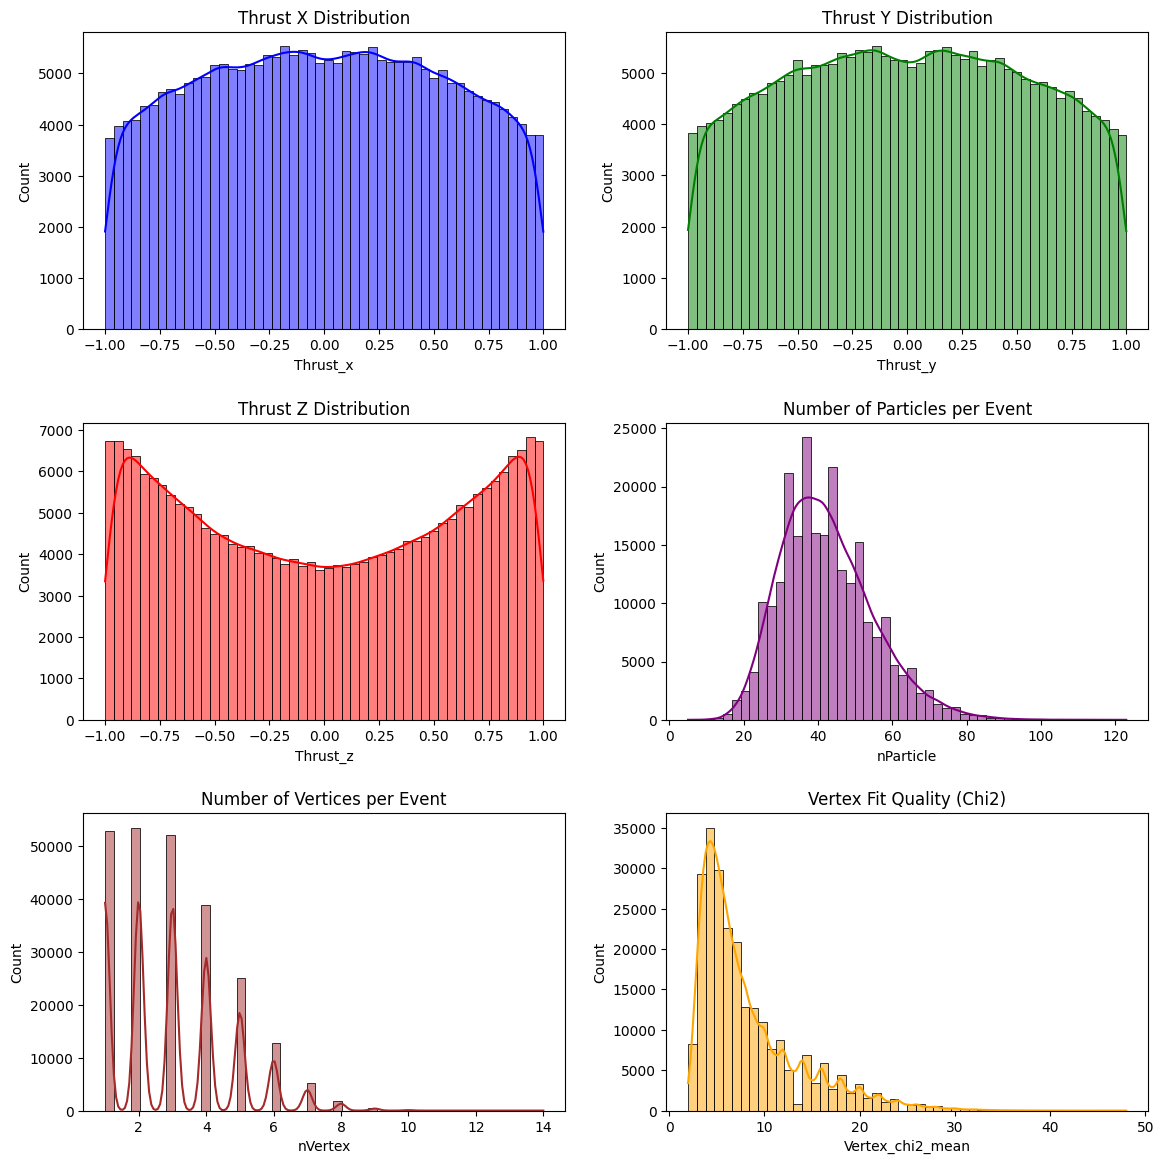

C:\Users\Alik\AppData\Local\Temp\ipykernel_1952\3623000985.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], ax=axes[2], palette="Set2")


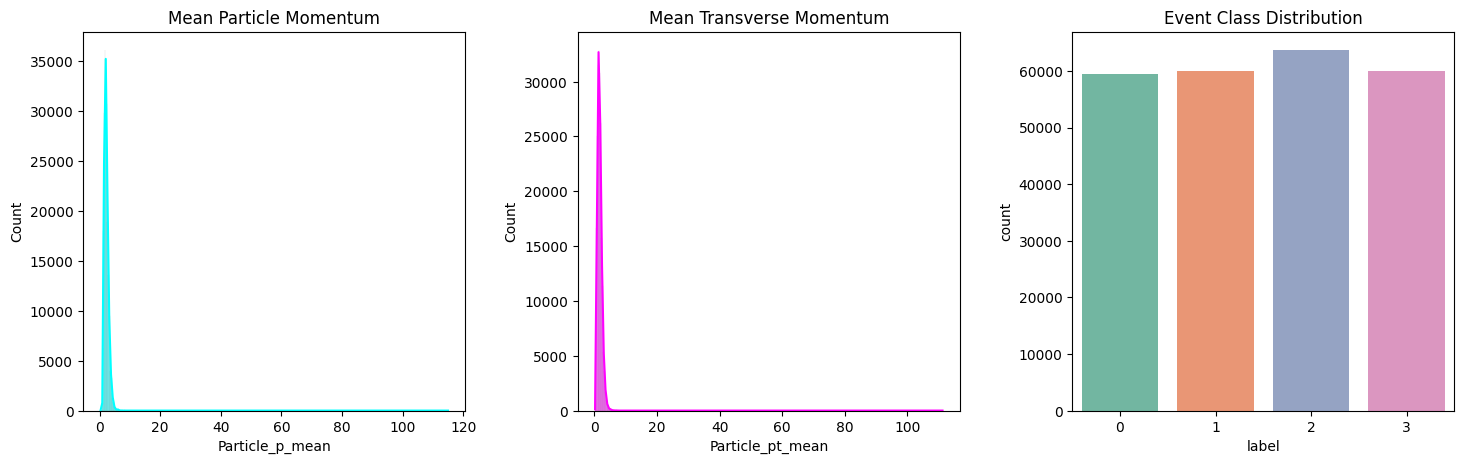

In [33]:
import ast

def visualize_data(df):
    """Generates various plots to understand the dataset."""
    
    # Convert object-type arrays to numerical lists
    def safe_eval_array(arr):
        return np.array([_a.mean() for _a in arr])
    
    # Apply conversion to array-type columns
    df['Particle_p_mean'] = safe_eval_array(np.array(df.Particle_p))
    df['Particle_pt_mean'] = safe_eval_array(np.array(df.Particle_pt))
    df['Particle_q_mean'] = safe_eval_array(np.array(df.Particle_q))
    df['Vertex_chi2_mean'] = safe_eval_array(np.array(df.Vertex_chi2_mean)) 

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    # Thrust Distributions
    sns.histplot(df['Thrust_x'], kde=True, ax=axes[0, 0], bins=50, color='blue')
    sns.histplot(df['Thrust_y'], kde=True, ax=axes[0, 1], bins=50, color='green')
    sns.histplot(df['Thrust_z'], kde=True, ax=axes[1, 0], bins=50, color='red')
    axes[0, 0].set_title('Thrust X Distribution')
    axes[0, 1].set_title('Thrust Y Distribution')
    axes[1, 0].set_title('Thrust Z Distribution')

    # Particle and Vertex Counts
    sns.histplot(df['nParticle'], bins=50, kde=True, ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Number of Particles per Event')

    sns.histplot(df['nVertex'], bins=50, kde=True, ax=axes[2, 0], color='brown')
    axes[2, 0].set_title('Number of Vertices per Event')

    # Vertex Fit Quality (Chi2)
    sns.histplot(df['Vertex_chi2_mean'], bins=50, kde=True, ax=axes[2, 1], color='orange')
    axes[2, 1].set_title('Vertex Fit Quality (Chi2)')

    plt.tight_layout(pad = 2)
    plt.show()

    # Additional Visualizations (Momentum, Charge, Label Distribution)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(df['Particle_p_mean'], bins=500, kde=True, ax=axes[0], color='cyan')
    axes[0].set_title('Mean Particle Momentum')

    sns.histplot(df['Particle_pt_mean'], bins=500, kde=True, ax=axes[1], color='magenta')
    axes[1].set_title('Mean Transverse Momentum')

    sns.countplot(x=df['label'], ax=axes[2], palette="Set2")
    axes[2].set_title('Event Class Distribution')

    plt.tight_layout(pad = 2)
    plt.show()

visualize_data(df)

In [87]:
def extract_features(events, labels):
    """
    Extract features from events for input to neural networks.
    
    Returns:
        X: Array of event features for each event
        y: Labels
    """

    events = np.array(events)
    labels = np.array(labels)

    n_events = len(events)

    # Define feature dimensions
    n_event_features = events.shape[-1]  # Thrust_x, Thrust_y, Thrust_z, nParticle, nVertex, Vertex_ntracks, Vertex_chi2_mean, Vertex_chi2_std, Particle_p, Particle_pt, Particle_q
    
    # Initialize arrays for event-level features and labels
    X = np.zeros((n_events, n_event_features))
    y = np.zeros(n_events, dtype=int)
    
    # Fill arrays with data
    for i, event in enumerate(events):
        # Fill label
        y[i] = labels[i]

        # Extract event-level features (thrust, particle, vertex, etc.)
        for j in range(n_event_features - 1):
            if isinstance(event[j], np.ndarray):
                X[i, j] = np.mean(event[j])
            else:
                X[i, j] = event[j]

    return X, y

# Extract features
X, y = extract_features(df.drop(columns=['label']), df.label)
print(np.unique(y))

rn_idx = np.random.permutation(len(y))  # Generate a random permutation of indices
X, y = zip(*[(X[i], y[i]) for i in rn_idx])
X, y = np.array(X), np.array(y)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print("Data split complete:")
print(f"Training: {len(y_train)} samples | X-shape: {X_train.shape}, y-shape: {y_train.shape} | UNQ-check: {np.unique(y_train)}")
print(f"Validation: {len(y_val)} samples | X-shape: {X_val.shape}, y-shape: {y_val.shape}")
print(f"Test: {len(y_test)} samples | X-shape: {X_test.shape}, y-shape: {y_test.shape}")

[0 1 2 3]
Data split complete:
Training: 145813 samples | X-shape: (145813, 14), y-shape: (145813,) | UNQ-check: [0 1 2 3]
Validation: 48605 samples | X-shape: (48605, 14), y-shape: (48605,)
Test: 48605 samples | X-shape: (48605, 14), y-shape: (48605,)


In [88]:
# Normalize the data (this is important for neural networks)
# For simplicity, we'll use a simple approach here

def normalize_features(X_train, X_val, X_test):
    # Reshape to 2D for scaling
    orig_shape = X_train.shape
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    # Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    
    # Transform all datasets
    X_train_scaled = scaler.transform(X_train_flat).reshape(orig_shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled

# Normalize jet and track features separately
X_train_norm, X_val_norm, X_test_norm = normalize_features(X_train, X_val, X_test)
print("Data normalization complete.")

Data normalization complete.


### Model Building 
I took the mean of all the sequential data like Particle_p, Particle_pt, Particle_q converting all of features to event-level - instead we can keep the sequential nature and a RNN like model  

In [93]:

# Build a model using the Keras functional API
# We'll use a combination of RNN and DeepSets approaches
def build_model(event_features, n_classes=4):
    """
    Build a neural network model for event classification.
    Uses only event-level features from your dataset.
    """
    # Input layer for event-level features
    input_layer = layers.Input(shape=(event_features,), name='event_input')
    
    # Dense layers for processing event-level features
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output layer with softmax activation for multi-class classification
    output_layer = layers.Dense(n_classes, activation='softmax', name='output')(x)
    
    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', ## not one-hot encoded
        metrics=['accuracy']
    )
    
    return model

# Event feature size is 11 based on your extracted features
event_features = X_train_norm.shape[-1]  # Thrust_x, Thrust_y, Thrust_z, nParticle, nVertex, Vertex_ntracks, Vertex_chi2_mean, Vertex_chi2_std, Particle_p, Particle_pt, Particle_q

# Build the model
model = build_model(event_features)

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,708 (940.27 KB)

 Trainable params: 240,708 (940.27 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:

# Train the model
history = model.fit(
    X_train_norm, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5, 
            patience=3
        )
    ]
)

Epoch 1/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5157 - loss: 1.0024 - val_accuracy: 0.2493 - val_loss: 25.3965 - learning_rate: 0.0010
Epoch 2/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5487 - loss: 0.9363 - val_accuracy: 0.2500 - val_loss: 26.2571 - learning_rate: 0.0010
Epoch 3/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5561 - loss: 0.9254 - val_accuracy: 0.2514 - val_loss: 13.6443 - learning_rate: 0.0010
Epoch 4/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5595 - loss: 0.9178 - val_accuracy: 0.2861 - val_loss: 20.7054 - learning_rate: 0.0010
Epoch 5/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5620 - loss: 0.9145 - val_accuracy: 0.2617 - val_loss: 13.2765 - learning_rate: 0.0010
Epoch 6/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5610 - loss: 0.9111 - val_accuracy: 0.4149 - val_loss: 1.2706 - learning_rate: 0.0010
Epoch 7/30
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy

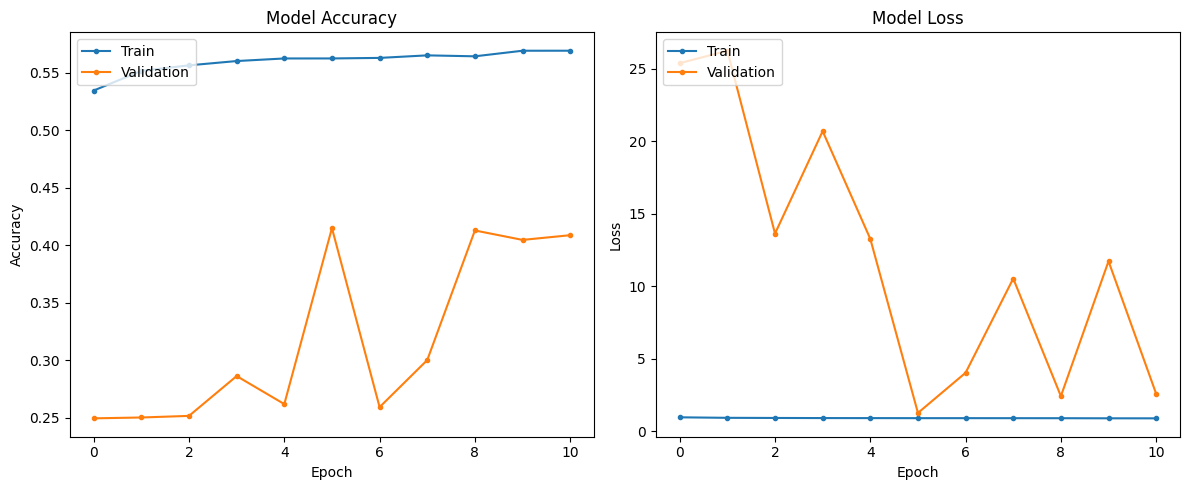

In [95]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker = '.')
plt.plot(history.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker = '.')
plt.plot(history.history['val_loss'], marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/training_history.png')
plt.show()

1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4141 - loss: 1.2675

Test accuracy: 0.4116
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.73      0.64      0.69     11930
         Zcc       0.31      0.07      0.11     11972
         Zss       0.13      0.06      0.08     12841
         Zud       0.36      0.90      0.52     11862

   micro avg       0.41      0.41      0.41     48605
   macro avg       0.38      0.42      0.35     48605
weighted avg       0.38      0.41      0.34     48605
 samples avg       0.41      0.41      0.41     48605



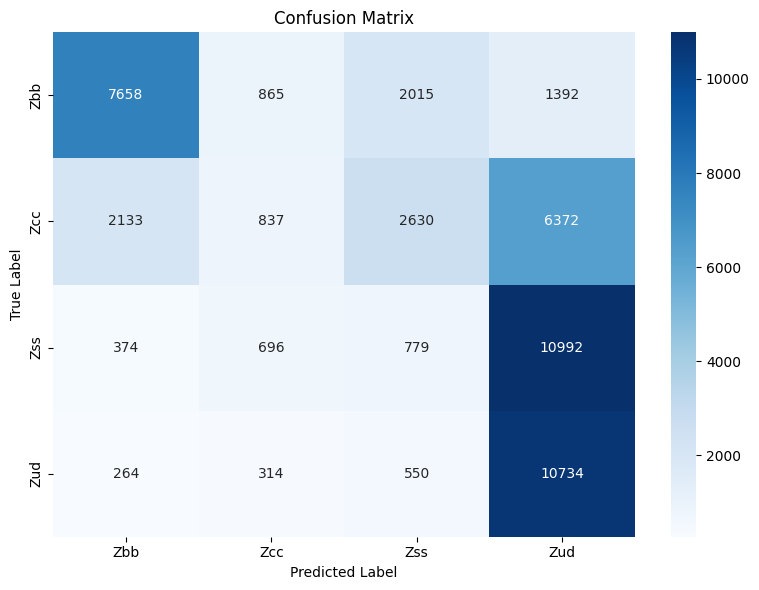

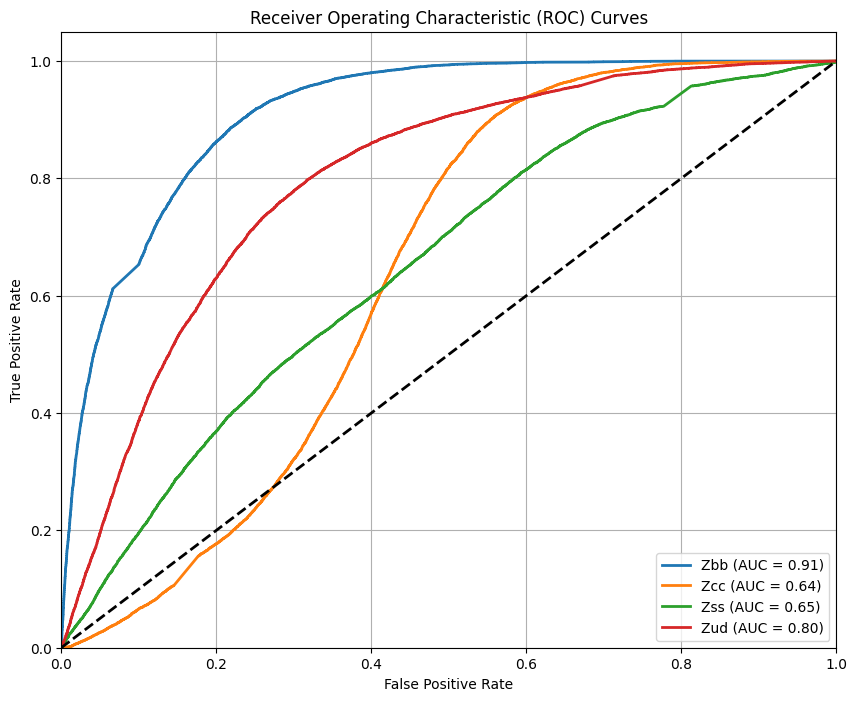

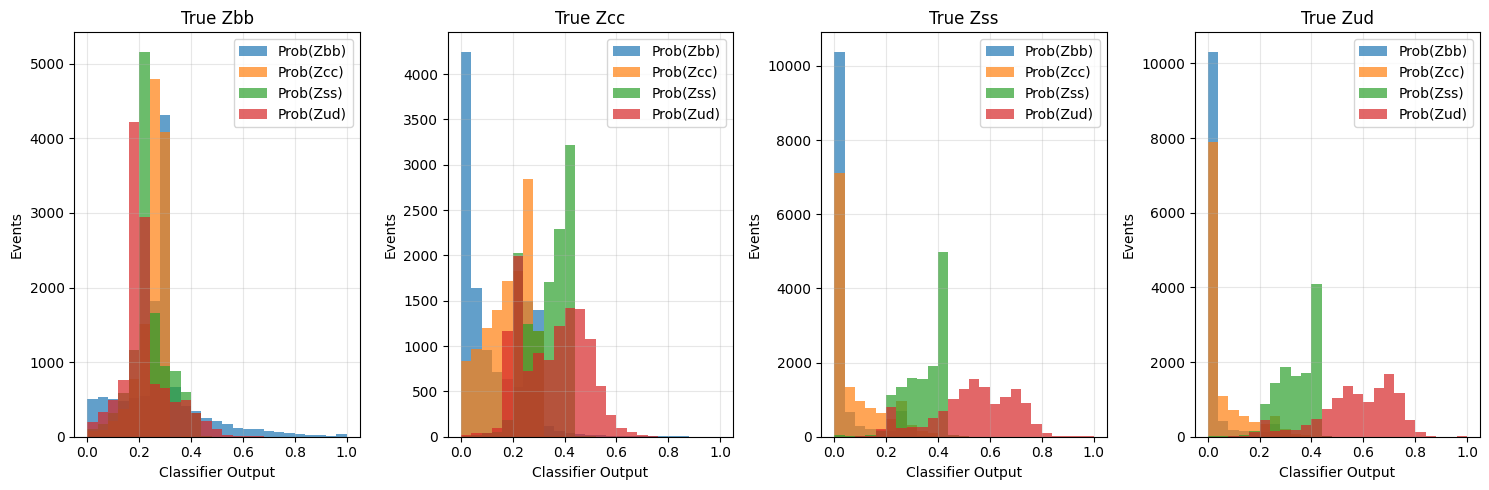

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from keras.utils import to_categorical

# Assuming that model is already trained, and X_test, y_test are defined

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the model
y_pred_prob = model.predict(X_test)  # Model expects one input (X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss', 'Zud']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'],
            yticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/confusion_matrix.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/roc_curves.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test == i)[0]
    
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
        plt.hist(y_pred_prob[true_indices, j], bins=25, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/classifier_outputs.png')
plt.show()